In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import shutil
import random
from multiprocessing.pool import ThreadPool

clear_output()

In [2]:
config = {
        "model_name_local":"DogCategory_v1.1",
        "note":"Модель предназнаена для определения категории к которой принадлежит собака",
        "batch_size":16,
        "input_image_height":60,
        "input_image_weight":70,
        "input_image_color_channels":3,
        "dropout_value": None,
        "epochs":100,
        "ft_epochs":100,
        "optimizer_name":"adam",
        "loss":"categorical_crossentropy",
        "learning_rate": 0.01,
        "learning_rate_ft": 0.001,
        "acc_metrics":"accuracy",
        "validation_split":0.2,
        "number_of_train_images":513,
        "number_of_test_images":126,
        "number_of_classes":2,
        "augmentation":True,
        "augmentation_description":"Горизонтальный переворот"
        }

In [3]:
PATH = "./data/2DogCategories_color_and_tail/tail"

In [6]:
def data_generator(PATH,batch_size,IMG_HEIGHT,IMG_WIDTH,validation_split,class_mode='binary'):
    
    #Выделяем тренировочный и тестовый датасеты
    train_dir = os.path.join(PATH)
    
    train_long_tail_dir = os.path.join(train_dir, 'only_long_tail')  
    train_short_tail_dir = os.path.join(train_dir, 'only_short_tail') 
      
    #Подсчитываем количество собак в каждом из классов
    num_long_tail_tr = len(os.listdir(train_long_tail_dir))
    num_short_tail_tr = len(os.listdir(train_short_tail_dir))
    
    total_train = num_long_tail_tr + num_short_tail_tr
    step_per_epoch_test = (total_train * validation_split) // batch_size
    step_per_epoch_train = (total_train - (total_train * validation_split)) // batch_size
    print("|Total dogs per class|")
    print('|only_long_tail:', num_long_tail_tr)
    print('|only_short_tail:', num_short_tail_tr)
    print(" ")
    print("|Total photosets: {}|".format(total_train))
    print(" ")
    print("|Steps per epochs train: {}|".format(step_per_epoch_train))
    print("|Steps per epochs test: {}|".format(step_per_epoch_test))
    print("--------------------------")
    print(" ")
    print("Class mode:", class_mode)
    train_image_generator = ImageDataGenerator(rescale=1./255,
                                               validation_split=validation_split) # Генератор для тренировочных данных
    
    print("Train DataGenerator:")
    train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                            color_mode="rgb",
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=class_mode,
                                                              subset='training')
    print(" ")
    print("Test DataGenerator:")
    val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                             color_mode="rgb",
                                                             shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode=class_mode,
                                                            subset='validation')
    return train_data_gen, val_data_gen, step_per_epoch_test, step_per_epoch_train

In [7]:
train_data_gen, val_data_gen, step_per_epoch_test, step_per_epoch_train  = data_generator(PATH,config['batch_size'],config['input_image_height'],config['input_image_weight'],config['validation_split'])

|Total dogs per class|
|only_long_tail: 307
|only_short_tail: 332
 
|Total photosets: 639|
 
|Steps per epochs train: 31.0|
|Steps per epochs test: 7.0|
--------------------------
 
Class mode: binary
Train DataGenerator:
Found 512 images belonging to 2 classes.
 
Test DataGenerator:
Found 127 images belonging to 2 classes.


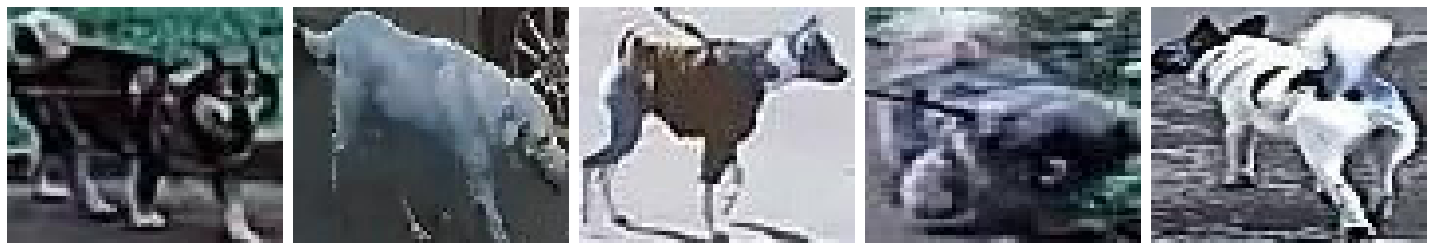

In [8]:
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

## Pretrained

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, concatenate, Activation, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD

import keras
from tensorflow.keras import layers

In [10]:
from tensorflow.keras.applications import ResNet50V2

RN = ResNet50V2(weights='imagenet', 
                  include_top=False,      
                  input_shape=(60, 70, 3))
RN.trainable = False               
#MN.summary() 

In [16]:
modelRN = Sequential()
modelRN.add(RN)

modelRN.add(Flatten())
modelRN.add(Dense(256, activation='relu'))
#modelRN.add(Dropout(0.5))
modelRN.add(Dense(2, activation='softmax'))

modelRN.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

modelRN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 3, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3145984   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 26,711,298
Trainable params: 3,146,498
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = './models/resnet_only_tails_v1.2'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
history = modelRN.fit(
        train_data_gen,
        steps_per_epoch=step_per_epoch_train,
        epochs=config["epochs"],
        validation_data=val_data_gen,
        validation_steps=step_per_epoch_test,
        #shuffle = True,
        callbacks=[es, save_best])

Epoch 1/100
31/31 [==============================] - 7s 52ms/step - loss: 1.1821 - accuracy: 0.4977 - val_loss: 0.9329 - val_accuracy: 0.5536
INFO:tensorflow:Assets written to: ./models/resnet_only_tails_v1.2/assets
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 0.7616 - accuracy: 0.6095 - val_loss: 0.8916 - val_accuracy: 0.5446
INFO:tensorflow:Assets written to: ./models/resnet_only_tails_v1.2/assets
Epoch 3/100
31/31 [==============================] - 1s 24ms/step - loss: 0.5501 - accuracy: 0.6942 - val_loss: 0.8856 - val_accuracy: 0.5536
INFO:tensorflow:Assets written to: ./models/resnet_only_tails_v1.2/assets
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 0.4679 - accuracy: 0.7704 - val_loss: 0.8935 - val_accuracy: 0.5714
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 0.3659 - accuracy: 0.8167 - val_loss: 0.9104 - val_accuracy: 0.5804
Epoch 6/100
31/31 [==============================] - 1s 25ms/step - 

## На ResNet 58,04%

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50V2

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import keras
from tensorflow.keras import layers

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [19]:
def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

def get_model_BCNN():
    dropout_value = config['dropout_value']
    input_shape = (config['input_image_height'], config['input_image_weight'], config['input_image_color_channels'])
    
    base_model_2 = ResNet50V2(include_top=False,input_shape=input_shape)    
    base_model_2.trainable = False
    base_model_2._name = "base_model_2"
    print("Number of layers in the base model-2: ", len(base_model_2.layers))
    
    base_model_1 = MobileNetV2(include_top=False,input_shape=input_shape)    
    base_model_1.trainable = False
    base_model_1._name = "base_model_1"
    print("Number of layers in the base model-1: ", len(base_model_1.layers))
          
    Input_1 = tf.keras.Input(input_shape)
    d1 = base_model_1(Input_1)
    d2 = base_model_2(Input_1)
    
    x = Lambda(outer_product, name = 'outer_product')([d1,d2])

    out = Dense(2, activation = 'softmax')(x)

    model_cancat = Model(inputs=Input_1, outputs=out)
    model_cancat.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=config["learning_rate"]), 
              metrics=['accuracy'])
    return model_cancat

In [20]:
with strategy.scope():
    model = get_model_BCNN()
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [21]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = './models/b-cnn_only_tails_v1.2'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
history = model.fit(
        train_data_gen,
        steps_per_epoch=step_per_epoch_train,
        epochs=config["epochs"],
        validation_data=val_data_gen,
        validation_steps=step_per_epoch_test,
        #shuffle = True,
        callbacks=[es, save_best])

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
31/31 [==============================] - 25s 237ms/step - loss: 0.8220 - accuracy: 0.6075 - val_loss: 1.2201 - val_accuracy: 0.5357
INFO:tensorflow:Assets written to: ./models/b-cnn_only_tails_v1.2/assets
Epoch 2/100
31/31 [==============================] - 2s 52ms/step - loss: 0.1179 - accuracy: 0.9552 - val_loss: 1.1589 - val_accuracy: 0.6161
INFO:tensorflow:Assets written to: ./models/b-cnn_only_tails_v1.2/assets
Epoch 3/100
31/31 [==============================] - 2s 53ms/step - loss: 0.0223 - accuracy: 0.9955 - val_loss: 1.2212 - val_accuracy: 0.6429
Epoch 4/100
31/31 [==============================] - 2s 52ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.2044 - val_accuracy: 0.6250
Epoch 5/100
31/31 [==============================] - 2s 52ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.

## На B-CNN 64,29%

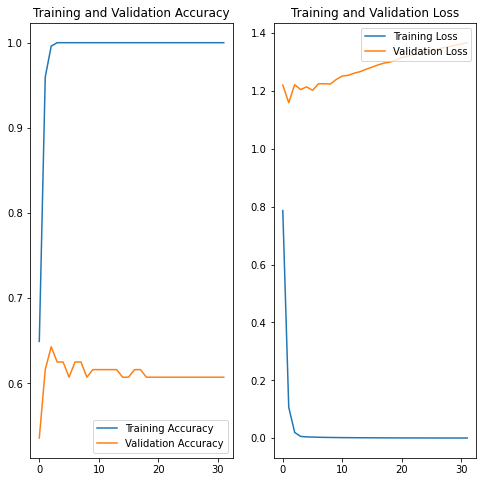

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

with strategy.scope():
#with tf.device('/cpu'):
    Y_pred = model.predict(val_data_gen)
    y_pred = np.argmax(Y_pred, axis=1)

In [24]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm / cm.astype(np.float).sum(axis=1)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('./saved_figure.png')
    
    image = cv2.imread("./saved_figure.png")
    return image

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['only_long_tail', 'only_short_tail']
report = classification_report(val_data_gen.classes, y_pred, target_names=target_names)
print(report)

                 precision    recall  f1-score   support

 only_long_tail       0.62      0.59      0.61        61
only_short_tail       0.64      0.67      0.65        66

      micro avg       0.63      0.63      0.63       127
      macro avg       0.63      0.63      0.63       127
   weighted avg       0.63      0.63      0.63       127



Normalized confusion matrix


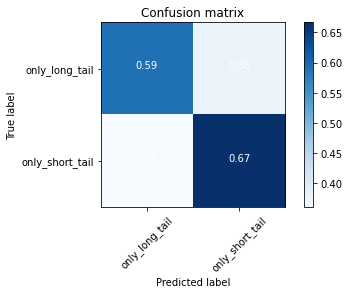

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import cv2
target_names = ['only_long_tail', 'only_short_tail']
image = plot_confusion_matrix(val_data_gen.classes, y_pred, target_names, normalize=True)